# (Draft) Nansen Legacy CTD postprocessing/water mass classification

Takes an .nc file (from NMDC) and exports the same .nc file with some additional content.

- **EOS80 variables** (*TEMP_NLEG, PSAL_NLEG, PRES_NLEG*) where we have replaced all instances where QC is not "good" with nans and applied some editing.
    - *Editing currently consists of just chopping away the upper 15 m - needs to be refined..* 
- **TEOS-10 variables** (*SA_NLEG, CT_NLEG, SIGMA0_NLEG*)
- **Buoyancy frequency squared** (N2_NLEG) and pressure at midpoints where N2 is computed (*PMIN_NLEG*)
- **Water mass classification** according to Sundfjord 2020:
    - *WMASS_STR_NLEG* contains strings ("PW", "mAW", etc)
    - *WMASS_NUM_NLEG* contains numerical values for each class 
        - (1=PW, 2=wPW, 3=AW, 4=mAW, 5=IW, 6=CBSDW, 7=EBDW/CBSDW)

Handling and modification of the netCDF file done with *xarray*.

TEOS-10 conversion and N2 calculation done using *gsw*.


NOTE: **THIS IS ONLY A DRAFT SCRIPT TO BE USED AS A STARTING POINT FOR A DISCUSSION!!**

In [25]:
import numpy as np
import gsw
import matplotlib.pyplot as plt
import xarray as xr

In [26]:
data_loc = '/home/oyvindl/work/projects/water_mass_aen/ctd_data/'
#ctdfile = 'NMDC_Nansen-Legacy_PR_CT_58US_2019711.nc'
ctdfile = 'NMDC_Nansen-Legacy_PR_CT_58US_2021704.nc'

### Load the dataset

In [3]:
d = xr.open_dataset(data_loc + ctdfile)

In [4]:
# Print time of first profile and summary to figure out what cruise 
# this is (and what to call the output file in the following cell)
print(d.TIME[0].data)
print(d.summary)

2021-04-29T16:37:48.000000000
The Nansen Legacy cruise Q2 (Q2: 2nd quarter of the year) was part of the seasonal investigation of the northern Barents Sea and adjacent Arctic Basin. The cruise was conducted during the spring period – a biologically critical time window when a large part of the annual primary production occurs – and focused on comparing the physical, chemical and biological conditions along the Nansen Legacy main transect in open waters and within the sea ice. The cruise addressed objectives of the work packages ‘Physical drivers’ (Research Focus 1), ‘Human impact’ (Research Focus 2), ‘The living Barents Sea’ (Research Focus 3) and ‘Technology and method development’ (Research Activity C).


In [5]:
### NOTE: MAKE SURE THIS IS RIGHT!! ####

outfile_name = 'CTDs_NLEG_Q2_2021.nc'
outfile_loc = '/home/oyvindl/work/projects/water_mass_aen/ctd_data/NLEG/'

## Making new T, S, P profiles where flags have been applied 

- Naning out ANY data point that is no classified as "good data" (QCflag != 1)
- Using the suffix "*_NLEG*" for any new fields created by us

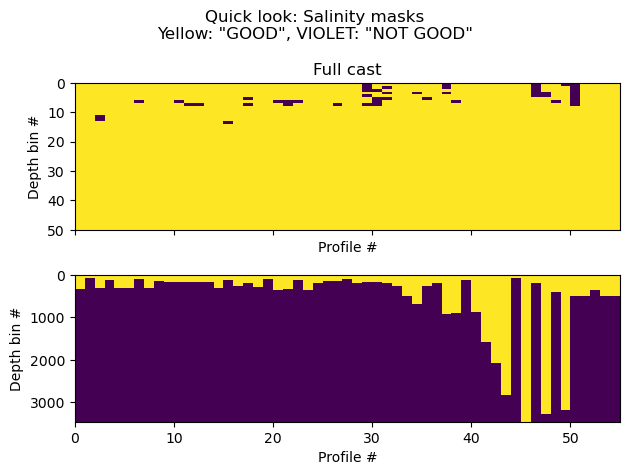

In [6]:
plot_good_PSAL = True # Quick plot of the flag

if plot_good_PSAL:
    fig, ax = plt.subplots(2,1, sharex = True)
    ax[0].pcolormesh(d['PSAL_QC'].T==1)
    ax[1].pcolormesh(d['PSAL_QC'].T==1)
    ax[0].set_ylim(50, 0)
    #ax[1].set_ylim(50, None)
    ax[1].invert_yaxis()
    for axn in ax:
        axn.set_ylabel('Depth bin #')
        axn.set_xlabel('Profile #')
    ax[0].set_title('Upper part of cast')
    ax[0].set_title('Full cast')
    fig.suptitle('Quick look: Salinity masks\nYellow: "GOOD", VIOLET: "NOT GOOD"')
    plt.tight_layout()

#### Applying flag -> nan

In [7]:
d['PSAL_NLEG'] = d.PSAL.where(d.PSAL_QC==1)
d['TEMP_NLEG'] = d.TEMP.where(d.TEMP_QC==1)
d['PRES_NLEG'] = d.PRES.where(d.PRES_QC==1)

#### Basic  editing
Some basic despiking/cleaning - we need to discuss how to do this, consider this a placeholder..

May want to do running filters or similar.

Currently, the approach is:

- **Removing *everything* above 15 db** (looks messy in ways that I think are suspicious - but I haven't looked very closely)

In [8]:
# Removing eveything above 15 db
d['PSAL_NLEG'] = d.PSAL_NLEG.where(d.PRES_NLEG>15)
d['TEMP_NLEG'] = d.TEMP_NLEG.where(d.PRES_NLEG>15)

In [9]:
# Add metadata attributes to these new variables

eos80_proc_flags_1 = ('NLEG post-processing: \nApplied all quality flags (set '
                     'all instances where [QC flag != 0] to NaN).')
eos80_proc_flags_2 = '\nChopped away all measurements above 15 m.'

d.TEMP_NLEG.attrs = {'standard_name': 'sea_water_temperature',
 'long_name': 'Sea temperature',
 'units': 'degrees_C',
 'note': eos80_proc_flags_1 + eos80_proc_flags_2}
d.PSAL_NLEG.attrs = {'standard_name': 'sea_water_practical_salinity',
 'long_name': 'Practical salinity',
 'units': '0.001',
 'note': eos80_proc_flags_1 + eos80_proc_flags_2}
d.PRES_NLEG.attrs = {'standard_name': 'sea_water_pressure',
 'long_name': 'Sea pressure',
 'units': 'dbar',
 'note': eos80_proc_flags_1}

# Computing gsw variables
Using the default algorithm -> includes the dSA coefficient from the dSA "atlas"

In [10]:
# Compute Absolute Salinity
SA = gsw.SA_from_SP(d.PSAL_NLEG.data, d.PRES_NLEG.data, 
                    d.LONGITUDE.data[:, np.newaxis], d.LATITUDE.data[:, np.newaxis])
d['SA_NLEG'] = (('TIME', 'DEPTH'), SA)

In [11]:
# Compute Conservative Temperature
CT = gsw.CT_from_t(SA, d.TEMP_NLEG.data, d.PRES_NLEG.data)
d['CT_NLEG'] = (('TIME', 'DEPTH'), CT)

In [12]:
# Compute Sigma0 density
sig0 = gsw.sigma0(SA, CT)
d['SIG0_NLEG'] = (('TIME', 'DEPTH'), sig0)

In [13]:
# Compute N2 at mid-pressure (note: this just applying the GSW algorithm. It  is sensitive to
# outliers - we may want to think about whether/how to do this.)

N2, P_mid = gsw.Nsquared(SA, CT, d.PRES_NLEG.data, d.LATITUDE.data[:, np.newaxis], axis = 1)
d.expand_dims({'DEPTH_MID':d.dims['DEPTH']-1})
d['PRES_MID_NLEG'] = (('TIME', 'DEPTH_MID'), P_mid)
d['N2_NLEG'] = (('TIME', 'DEPTH_MID'), N2)

In [14]:
# Add metadata attributes 

d.SA_NLEG.attrs = {'standard_name': 'sea_water_absolute_salinity',
 'long_name': 'Absolute Salinity', 'units': 'g kg-1',
 'note': ('Absolute Salinity calculated from (PSAL_NLEG, PRES_NLEG, LONGITUDE, LATITUDE) using'
          ' the *gsw* module (https://teos-10.github.io/GSW-Python/. The dSA coefficient was '
          'taken from the gsw-atlas.')}
d.CT_NLEG.attrs = {'standard_name': 'sea_water_conservative_temperature',
 'long_name': 'Conservative Temperature', 'units': 'degrees_C',
 'note': ('Conservative Temperature calculated from (SA_NLEG, TEMP_NLEG, PRES_NLEG) using'
          ' the *gsw* module (https://teos-10.github.io/GSW-Python/.')}
d.SIG0_NLEG.attrs = {'standard_name': 'sea_water_sigma_t',
 'long_name': 'Potential density anomaly with reference pressure of 0 dbar'
 'this being this particular potential density minus 1000 kg/m^3.', 'units': 'kg m-3',
 'note': ('Potential density anomaly sigma0 calculated from (SA_NLEG, CT_NLEG) using'
          ' the *gsw* module (https://teos-10.github.io/GSW-Python/.')}
d.N2_NLEG.attrs = {'standard_name': 'square_of_brunt_vaisala_frequency_in_sea_water',
 'long_name': 'Buoyancy frequency squared', 'units': 's-2',
 'note': ('Buoyancy frequency squared calculated from (SA_NLEG, CT_NLEG, PRES_NLEG LONGITUDE,'
          'LATITUDE) using the *gsw* module (https://teos-10.github.io/GSW-Python/.\n'
          'Vertical (pressure) grid: PRES_MID_NLEG'
          'Note: Calculated from unsmoothed profiles; very sensitive to noise. USE WITH CAUTION!')}
d.PRES_MID_NLEG.attrs = {'standard_name': 'sea_water_pressure',
 'long_name': 'Sea pressure', 'units': 'dbar',
 'note': ('Ocean pressure at mid-values where N2_NLEG is computed.')}

# Water mass classification

### Define a classifier function 

In [15]:
def classify(SA, CT, sig0):
    '''
    Reads (single) values of SA, CT, and sig0 and classifies the mesurements in the
    water mass space from Sundfjord et al 2020
    '''
    if (CT<=0) and (sig0<=27.97):
        wm, wmnum = 'PW', 1
    elif (CT>0) and (SA<35.06):
        wm, wmnum = 'wPW', 2   
    elif (CT>2) and (SA>=35.06):
        wm, wmnum = 'AW', 3  
    elif (CT<=2) and (CT>0 and SA>=35.06):
        wm, wmnum = 'mAW', 4  
    elif (CT>-1.1) and (CT<=0 and sig0>27.97):
        wm, wmnum = 'IW', 5  
    elif (CT<=-1.1) and (sig0>27.97):
        wm, wmnum = 'CBDSW', 6
        if (SA>=35.06):
            wm, wmnum = 'EBDW/CBSDW', 7  
    try:
        return wm, wmnum
    except:
        print(CT, SA, sig0)

In [16]:
# Quick test
nn, mm =30, 30
classify(SA[nn, mm], CT[nn, mm], sig0[nn, mm])

('PW', 1)

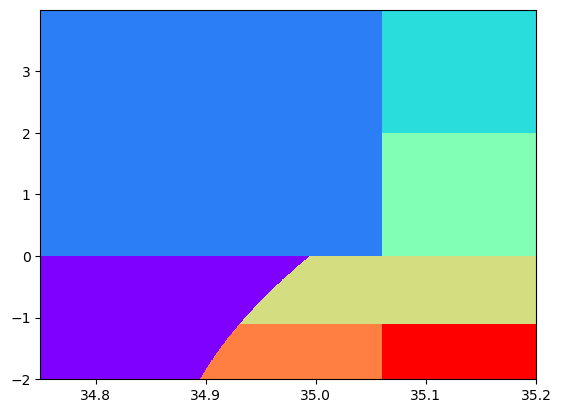

In [17]:
# Option:
# Take a quick look at the water mass distribution as defined by 
# the classify() function in SA-CT space

quicklook_classifier = True

if quicklook_classifier:
    SAarr = np.arange(34.75, 35.2, 0.0005)
    CTarr = np.arange(-2, 4, 0.001)
    SA, CT = np.meshgrid(SAarr, CTarr)
    sig0 = gsw.sigma0(SA, CT)

    WMNUM = SA*np.nan
    for nn in np.arange(WMNUM.shape[0]):
        for mm in np.arange(WMNUM.shape[1]):
            wm, WMNUM[nn, mm] = classify(SA[nn, mm], CT[nn, mm], sig0[nn, mm])

    fig, ax = plt.subplots()
    ax.pcolormesh(SAarr, CTarr, WMNUM, cmap = 'rainbow')

### Apply to the CTD dataset

In [18]:
CTD_WMS_num = np.nan*np.ones([d.dims['TIME'], d.dims['DEPTH']])
CTD_WMS_str = (np.nan*np.ones([d.dims['TIME'], d.dims['DEPTH']])).tolist()

for nn in np.arange(d.dims['TIME']):
    for mm in np.arange(d.dims['DEPTH']):
        SA_, CT_, sig0_ =  d.SA_NLEG.data[nn, mm], d.CT_NLEG.data[nn, mm], d.SIG0_NLEG.data[nn, mm]
        if not np.isnan([SA_, CT_]).any():
            CTD_WMS_str[nn][mm], CTD_WMS_num[nn, mm] = classify(SA_, CT_, sig0_)
        else:
            CTD_WMS_str[nn][mm] = ''

d['WMASS_STR_NLEG'] = (('TIME', 'DEPTH'), CTD_WMS_str)
d['WMASS_NUM_NLEG'] = (('TIME', 'DEPTH'), CTD_WMS_num)

In [19]:
# ADD METADATA ATTRIBUTES TO THE WATER MASS FIELDS

# A general cautionary note to be applied to the water mass fields..
user_wm_warning = ('\n**PROCEED WITH CAUTION**: Water mass analysis in T-S space is a useful '
       'tool, but any classification scheme is a rough and somewhat subjective approximation.'
       ' The Sundfjord 2020 framework is one compromise that will do a good job in some cases and'
       " less so in others.\n\n-> Remember to *look at your data*, and don't blindly rely on"
        ' water mass classifactions!')

# A note about the "EBDW/CBSDW" class
ebdw_cbdsw_note = ('Needs other contextual information to differentiate between EBDW and CBDSW. '
    'From Sundfjord et al. (2020): \n\n'
    'Eurasian Basin Deep Water (EBDW) can be used for waters beyond the 500 m isobath over the'
                   ' continental slope North of the Barents Sea.')

d.WMASS_STR_NLEG.attrs = {
 'long_name': 'Water mass classification (STRING)',
 'reference': ('Sundfjord et al. (2020): Suggested water mass definitions'
    ' for the central and northern Barents Sea, and the adjacent Nansen '
    'Basin: Workshop Report'),
 'reference_doi': 'https://doi.org/10.7557/nlrs.5707 ',
 'description': ('Water mass classification based on (SA_NLEG, CT_NLEG, SIGMA0_NLEG). Water'
                 ' masses (TEOS-10) from Sundfjord et al (2020). '
                '\nString values ("AW", "wPW", etc..)'),
 'ebdw_cbdsw_note': ebdw_cbdsw_note,
 'note_to_users': user_wm_warning}

d.WMASS_NUM_NLEG.attrs = {
 'long_name': 'Water mass classification (INTEGER)',
 'reference': ('Sundfjord et al. (2020): Suggested water mass definitions'
    ' for the central and northern Barents Sea, and the adjacent Nansen '
    'Basin: Workshop Report'),
 'reference_doi': 'https://doi.org/10.7557/nlrs.5707',
 'description': ('Water mass classification based on (SA_NLEG, CT_NLEG, SIGMA0_NLEG). Water'
                 ' masses (TEOS-10) from Sundfjord et al (2020). '
                'The water masses corresponding to each integer value can be found in '
                 '*wm_integer_key*'),
 'wm_integer_key': ('1=PW, 2=wPW, 3=AW, 4=mAW, 5=IW, 6=CBSDW, 7=EBDW/CBSDW*\n'
    '*see ebdw_cbdsw_note'),
 'ebdw_cbdsw_note': ebdw_cbdsw_note,
 'note_to_users': user_wm_warning}


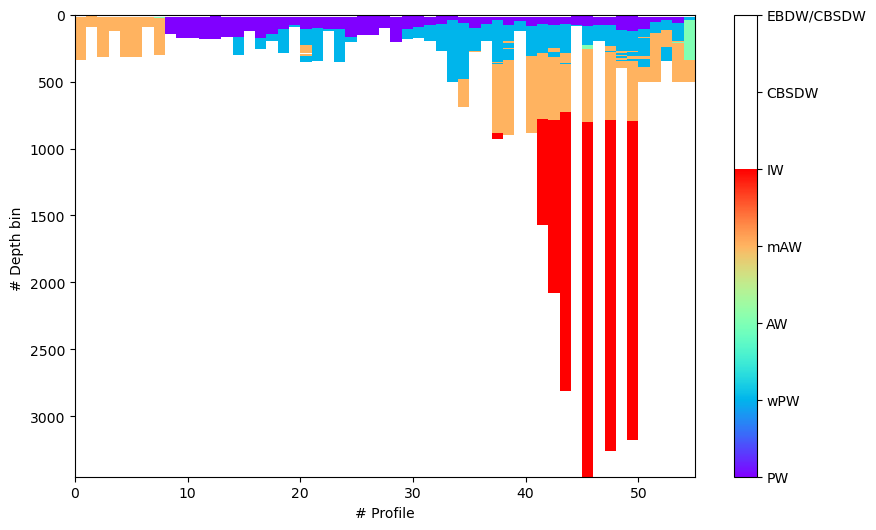

In [20]:
# Optional: quick plot 

show_ctd_classification = True

if show_ctd_classification:
    fig, ax = plt.subplots(figsize = (10, 6))
    C = ax.pcolormesh(d['WMASS_NUM_NLEG'].T, cmap = 'rainbow')
    ax.invert_yaxis()
    cb = plt.colorbar(C, ticks = [0, 1, 2, 3, 4, 5, 6, 7])
    cb.ax.set_yticks([1, 2, 3, 4, 5, 6, 7])
    cb.ax.set_yticklabels(['PW', 'wPW', 'AW', 'mAW', 'IW', 'CBSDW', 'EBDW/CBSDW'])
    ax.set_ylabel('# Depth bin ')
    ax.set_xlabel('# Profile');

#### Add some general metadata attributes

In [22]:
d.attrs['contact'] = (d.attrs['contact'] + 
    ' (for _NLEG variables and water masses: see "NLEG_contact")')
d.attrs['references'] = (d.attrs['references'] + 
    ', Sundfjord et al (2020): https://doi.org/10.7557/nlrs.5707')
d.attrs['NLEG_contact'] = ('Arild Sundfjord: arild.sundfjord@npolar.no\n'
                           'Karen Assmann: karen.assmann@hi.no\n'
                           'Øyvind Lundesgaard: oyvind.lundesgaard@npolar.no\n'
                           'Angelika H.H. Renner: angelika.renner@hi.no\n'
                           'Randi Ingvaldsen: randi.ingvaldsen@hi.no')
d.attrs['history'] = ('"_NLEG" variables and water mass classifications were appended to the file'
                     ' by Nansen Legacy water mass working group (see "NLEG_contact"). '
                     'More information in the attributes of individual "_NLEG" variables.')
d.attrs['summary'] = (d.attrs['summary'] +'\n\n'+ d.attrs['history'])

# Save

In [23]:
d.to_netcdf(outfile_loc + outfile_name)
print('Saved to %s'%(outfile_loc + outfile_name))

Saved to /home/oyvindl/work/projects/water_mass_aen/ctd_data/NLEG/CTDs_NLEG_Q2_2021.nc
